Install library for QC

In [178]:
%pip install dwave-ocean-sdk
%pip install dwave-neal

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Подключим все необходимые библиотеки

In [179]:
import random
import math
import itertools
from datetime import datetime
import time
import numpy as np
from typing import *
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import dimod
from dimod import BinaryQuadraticModel
from dimod.reference.samplers import ExactSolver
from neal import SimulatedAnnealingSampler
from qdeepsdk import QDeepHybridSolver

Сгенерируем случайные данные

In [180]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"({self.x}, {self.y})"

def distance(p1: Point, p2: Point) -> int:
    return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

class TestCase:
    def __init__(self):
        self.ClientsNum = 0
        self.DepotsNum = 0
        self.CarsNum = 0
        self.ClientPositions = []
        self.DepotPositions = []
        self.CarDepot = []
        self.CarDepotMap = {}

    def __repr__(self):
        res = ""
        res += f"ClientsNum: {self.ClientsNum}\n"
        res += f"DepotsNum: {self.DepotsNum}\n"
        res += f"CarsNum: {self.CarsNum}\n"
        res += f"ClientPositions: {self.ClientPositions}\n"
        res += f"DepotPositions: {self.DepotPositions}\n"
        res += f"CarDepot: {self.CarDepotMap}\n"
        return res

    def DistClients(self, i: int, j: int) -> int:
        return distance(self.ClientPositions[i], self.ClientPositions[j])
    
    def DistDepotClient(self, d: int, c: int) -> int:
        return distance(self.DepotPositions[d], self.ClientPositions[c])

def GenerateTestCase(clientsNum: int, depotsNum: int, carsNum: int, maxPos: int)-> TestCase:

    if carsNum < depotsNum:
        raise Exception("Cars number is less than depots number")

    res = TestCase()
    res.ClientsNum = clientsNum
    res.DepotsNum = depotsNum
    res.CarsNum = carsNum
    res.CarDepot = [[0 for _ in range(depotsNum)] for _ in range(carsNum)]

    for i in range(clientsNum):
        res.ClientPositions.append(Point(random.randint(0, maxPos), random.randint(0, maxPos)))

    for i in range(depotsNum):
        res.DepotPositions.append(Point(random.randint(0, maxPos), random.randint(0, maxPos)))

    for i in range(depotsNum):
        res.CarDepot[i][i] = 1
        res.CarDepotMap[i] = i

    for i in range(depotsNum, carsNum):
        depot = random.randint(0, depotsNum - 1)
        res.CarDepot[i][depot] = 1
        res.CarDepotMap[i] = depot

    return res

Напишем функцию для раскрытия выражения вида $(a_1 + a_2 + ... + a_n)^2$, потому что почти все ограничения к этому сводятся

In [181]:
# Input [(1, "x1"), (-2, "x3")]
# Output ({"x1": 1, "x3": 4}, {("x1", "x3"): -4})
def square(vals: list)-> tuple:

    res = ({}, {})

    for val in vals:
        if val[1] != "":
            if val[1] not in res[0].keys():
                res[0][val[1]] = 0
            res[0][val[1]] += val[0] * val[0]
        
    for v1 in vals:
        for v2 in vals:
            if v1[1] == v2[1]:
                continue
            if v1[1] == "" and v2[1] == "":
                continue

            if v1[1] != "" and v2[1] != "":
                if (v1[1], v2[1]) not in res[1].keys():
                    res[1][(v1[1], v2[1])] = 0
                res[1][(v1[1], v2[1])] += v1[0] * v2[0]
            else:
                if v1[1]+v2[1] not in res[0].keys():
                    res[0][v1[1]+v2[1]] = 0
                res[0][v1[1]+v2[1]] += v1[0] * v2[0]

    return res

print(square([(1, "x1"), (-2, "x3"), (1, "")]))

({'x1': 3, 'x3': 0}, {('x1', 'x3'): -2, ('x3', 'x1'): -2})


Создадим класс модели QUBO:

In [182]:
class QUBOModel:
    def __init__(self):
        self.h = dict()
        self.J = dict()
        self.BigConstant = 100000
        self.id = 0 # serail key for constructing values in inequalities

    def AddCoef(self, coefs: tuple):
        for key in coefs[0]:
            if key not in self.h.keys():
                self.h[key] = 0
            self.h[key] += coefs[0][key]
        
        for key in coefs[1]:
            if key not in self.J.keys():
                self.J[key] = 0
            self.J[key] += coefs[1][key]

    def PrepareCoefs(self):
        for k1 in self.h.keys():
            for k2 in self.h.keys():
                if k1 != k2 and (k1, k2) in self.J.keys() and (k2, k1) in self.J.keys():
                    self.J[(k1, k2)] += self.J[(k2, k1)]
                    del self.J[(k2, k1)]

    def GetLists(self)-> tuple:
        self.PrepareCoefs()
        return (self.h, self.J)

    def GetMatrix(self)-> tuple: # matrix (QUBO) + list (pos->argname) + map (argname->pos)
        self.PrepareCoefs()
        NamesArr = list(self.h.keys())
        NamesMap = dict()
        for i in range(len(NamesArr)):
            NamesMap[NamesArr[i]] = i

        Matrix = np.zeros((len(NamesArr), len(NamesArr)), dtype=int)

        for key in self.h:
            Matrix[NamesMap[key]][NamesMap[key]] = self.h[key]

        for key in self.J:
            Matrix[NamesMap[key[0]]][NamesMap[key[1]]] = self.J[key]

        return (Matrix, NamesArr, NamesMap)


_Целевая функция:_ Функия описывающая издержки для передвижения всех машин. Данную функцию мы хотим минимизировать.

In [183]:
def min_func(test: TestCase, model: QUBOModel):
    for k in range(test.CarsNum):
        for i in range(test.ClientsNum):
            for j in range(test.ClientsNum):
                model.AddCoef(({f"x{i}_{j}_{k}": test.DistClients(i, j)}, {}))

    for k in range(test.CarsNum):
        for i in range (test.ClientsNum):
            for d in range(test.DepotsNum):
                model.AddCoef(({f"u{i}_{k}": test.DistDepotClient(d, i)*test.CarDepot[k][d]}, {}))

    for k in range(test.CarsNum):
        for i in range (test.ClientsNum):
            for d in range(test.DepotsNum):
                model.AddCoef(({f"n{i}_{k}": test.DistDepotClient(d, i)*test.CarDepot[k][d]}, {}))

_Ограничение 1:_ Нельзя поехать к тому же покупателю.

In [184]:
def constraint_1(test: TestCase, model: QUBOModel):
    for i in range(test.ClientsNum):
        for k in range(test.CarsNum):
            model.AddCoef(({f"x{i}_{i}_{k}": model.BigConstant}, {}))

_Ограничение 2:_ К каждому покупателю должна приехать ровно одна машина.

In [185]:
def constraint_2(test: TestCase, model: QUBOModel):
    for i in range(test.ClientsNum):

        vals = []
        vals.append((model.BigConstant, ""))

        for k in range(test.CarsNum):
            for j in range(test.ClientsNum):
                vals.append((-model.BigConstant, f"x{j}_{i}_{k}"))
            vals.append((-model.BigConstant, f"u{i}_{k}"))

        model.AddCoef(square(vals))

_Ограничение 3:_ От каждого покупателя должна уехать ровно одна машина.

In [186]:
def constraint_3(test: TestCase, model: QUBOModel):
    for i in range(test.ClientsNum):

        vals = []

        vals.append((model.BigConstant, ""))

        for k in range(test.CarsNum):
            for j in range(test.ClientsNum):
                vals.append((-model.BigConstant, f"x{i}_{j}_{k}"))
            vals.append((-model.BigConstant, f"n{i}_{k}"))

        model.AddCoef(square(vals))

_Ограничение 4:_ Каждая машина должна отъехать ровно с одного склада.

In [187]:
def constraint_4(test: TestCase, model: QUBOModel):
    for k in range(test.CarsNum):

        vals = []

        vals.append((model.BigConstant, ""))

        for i in range(test.ClientsNum):
            vals.append((-model.BigConstant, f"u{i}_{k}"))

        model.AddCoef(square(vals))

_Ограничение 5:_ Каждая машина должна приехать ровно на один склад.

In [188]:
def constraint_5(test: TestCase, model: QUBOModel):
    for k in range(test.CarsNum):

        vals = []

        vals.append((model.BigConstant, ""))

        for i in range(test.ClientsNum):
            vals.append((-model.BigConstant, f"n{i}_{k}"))

        model.AddCoef(square(vals))

_Ограничение 6:_ "Целостность маршрута". Если машина приехала к покупателю, то она должна уехать от него.

In [189]:
def constraint_6(test: TestCase, model: QUBOModel):
    for i in range(test.ClientsNum):
        for k in range(test.CarsNum):
            
            vals = []

            vals.append((model.BigConstant, f"u{i}_{k}"))
            vals.append((-model.BigConstant, f"n{i}_{k}"))

            for j in range(test.ClientsNum):
                vals.append((model.BigConstant, f"x{j}_{i}_{k}"))
                vals.append((-model.BigConstant, f"x{i}_{j}_{k}"))

            model.AddCoef(square(vals))

_Ограничение 7:_ У машин не должно быть возможности иметь на своем маршруте цикл из городов, который они не посещают.

In [190]:
def get_subsets(n):
    res = []
    for i in range(1 << n):
        cur = []
        for j in range(n):
            if (i & (1 << j)):
                cur.append(j)
        res.append(cur)
    return res

def constraint_7(test: TestCase, model: QUBOModel):
    for S in get_subsets(test.ClientsNum):
        if len(S) >= 2:

            vals = []

            vals.append((model.BigConstant * (-len(S) + 1), ""))

            for k in range(test.CarsNum):
                for i in S:
                    for j in S:
                        if i != j:
                            vals.append((model.BigConstant, f"x{i}_{j}_{k}"))

            for l in range(math.ceil(math.log2(len(S)))):
                
                model.id += 1
                vals.append((2**l * model.BigConstant, f"l{model.id}"))

            model.AddCoef(square(vals))

_Ограничение 10:_ Аналогичное ограничению 7, но работающее быстрее :)

In [191]:
def constraint_10(test: TestCase, model: QUBOModel):
    log_t = math.ceil(math.log2(test.ClientsNum + 1))

    for i in range(test.ClientsNum):
        for j in range(test.ClientsNum):

            if i == j:
                continue

            vals = []
            vals.append((model.BigConstant * (-test.ClientsNum + 1), ""))

            for k in range(test.CarsNum):
                vals.append((model.BigConstant * test.ClientsNum, f"x{i}_{j}_{k}"))

            for l in range(math.ceil(math.log2(test.ClientsNum + 1))):
                vals.append((2 ** l * model.BigConstant, f"t{l}_{i}"))
                vals.append((-(2 ** l) * model.BigConstant, f"t{l}_{j}"))

            for l in range(1 + math.ceil(math.log2(test.ClientsNum + 1))):
                model.id += 1
                vals.append((2 ** l * model.BigConstant, f"l{model.id}"))

            model.AddCoef(square(vals))
            

Сгенерируем пример теста

In [192]:
test = GenerateTestCase(4, 1, 1, 100)

print("TestCase:")
print(test)

def constructQUBO(test: TestCase) -> QUBOModel:
    res = QUBOModel()
    min_func(test, res)
    constraint_1(test, res)
    constraint_2(test, res)
    constraint_3(test, res)
    constraint_4(test, res)
    constraint_5(test, res)
    constraint_6(test, res)

    return res

qubo7 = constructQUBO(test)
constraint_7(test, qubo7)

qubo10 = constructQUBO(test)
constraint_10(test, qubo10)

print("QUBO7 params:", len(qubo7.GetLists()[0]), "Matrix:", qubo7.GetMatrix()[0].shape)
print("QUBO10 params:", len(qubo10.GetLists()[0]), "Matrix:", qubo10.GetMatrix()[0].shape)

TestCase:
ClientsNum: 4
DepotsNum: 1
CarsNum: 1
ClientPositions: [(58, 8), (82, 70), (39, 55), (29, 8)]
DepotPositions: [(16, 67)]
CarDepot: {0: 0}

QUBO7 params: 40 Matrix: (40, 40)
QUBO10 params: 84 Matrix: (84, 84)


Создадим класс решения

In [193]:
class Movement:
    def __init__(self, Car, From, To):
        self.Car = Car
        self.From = From
        self.To = To

    def __repr__(self):
        return f"({self.Car}: {self.From} -> {self.To})"

class FromDepot:
    def __init__(self, Car, Depot, To):
        self.Car = Car
        self.To = To
        self.Depot = Depot
    
    def __repr__(self):
        return f"({self.Car}: Depot{self.Depot} -> {self.To})"

class ToDepot:
    def __init__(self, Car, From, Depot):
        self.Car = Car
        self.From = From
        self.Depot = Depot

    def __repr__(self):
        return f"({self.Car}: {self.From} -> Depot{self.Depot})"


class SolutionCase:
    def __init__(self):
        self.Error = ""
        self.Movements = [] # list of edges quantum computer returned
        self.FromDepot = []
        self.ToDepot = []
        self.Energy = -1
    
    def AddMovement(self, Car: int, From: int, To: int):
        self.Movements.append(Movement(Car, From, To))

    def AddFromDepot(self, Car, Depot, To):
        self.FromDepot.append(FromDepot(Car, Depot, To))

    def AddToDepot(self, Car, From, Depot):
        self.ToDepot.append(ToDepot(Car, From, Depot))

    def CheckErrors(self, test: TestCase) -> str: # empty for no error
        
        # Constraint 1
        for m in self.Movements:
            if m.From == m.To:
                return f"Found cycle in city{m.From}"
        
        # Constraint 2, 3
        fromCount = [0 for _ in range(test.ClientsNum)]
        toCount = [0 for _ in range(test.ClientsNum)]
        for m in self.Movements:
            fromCount[m.From] += 1
            toCount[m.To] += 1
        for m in self.FromDepot:
            toCount[m.To] += 1
        for m in self.ToDepot:
            fromCount[m.From] += 1
        for c in range(test.ClientsNum):
            if fromCount[c] != 1:
                return f"From client {c} leaved {fromCount[c]} cars"
            if toCount[c] != 1:
                return f"To client {c} arrived {toCount[c]} cars"
            
        # Constraint 4, 5
        fromDepot = [0 for _ in range(test.CarsNum)]
        toDepot = [0 for _ in range(test.CarsNum)]
        for m in self.FromDepot:
            if test.CarDepotMap[m.Car] != m.Depot:
                return f"Car {m.Car} should leave from {test.CarDepotMap[m.Car]} depot, instead of {m.Depot}"
            fromDepot[m.Car] += 1
        for m in self.ToDepot:
            if test.CarDepotMap[m.Car] != m.Depot:
                return f"Car {m.Car} should arrive at {test.CarDepotMap[m.Car]} depot, instead of {m.Depot}"
            toDepot[m.Car] += 1

        for c in range(test.CarsNum):
            if fromDepot[c] != 1:
                return f"Car {c} leaved from {fromDepot[c]} depots"
            if toDepot[c] != 1:
                return f"Car {c} arrived to {toDepot[c]} depots"
            
        # Constraint 6, 7
        Next = [[-1 for _ in range(test.ClientsNum)] for _ in range(test.CarsNum)]
        FirstClient = [-1 for _ in range(test.CarsNum)]
        LastClient = [-1 for _ in range(test.CarsNum)]
        Used = [0 for _ in range(test.ClientsNum)]

        for m in self.FromDepot:
            FirstClient[m.Car] = m.To

        for m in self.ToDepot:
            LastClient[m.Car] = m.From

        for m in self.Movements:
            Next[m.Car][m.From] = m.To

        for c in range(test.CarsNum):
            cur = FirstClient[c]
            Used[cur] += 1

            while cur != LastClient[c]:
                if Next[c][cur] == -1:
                    return f"No next client for car {c}  for client {cur}"
                
                cur = Next[c][cur]
                Used[cur] += 1

        for c in range(test.ClientsNum):
            if Used[c] != 1:
                return f"Client {c} visited {Used[c]} times, must be 1"
            
        return ""
    
    def GetCost(self, test: TestCase) -> float:
        ans = 0

        for i in self.Movements:
            ans += test.DistClients(i.From, i.To)

        for i in self.FromDepot:
            ans += test.DistDepotClient(i.Depot, i.To)

        for i in self.ToDepot:
            ans += test.DistDepotClient(i.Depot, i.From)

        return ans
    
    def GetPath(self, test: TestCase) -> str:
        ans = ""

        Next = [[-1 for _ in range(test.ClientsNum)] for _ in range(test.CarsNum)]
        FirstClient = [-1 for _ in range(test.CarsNum)]
        LastClient = [-1 for _ in range(test.CarsNum)]

        for m in self.FromDepot:
            FirstClient[m.Car] = m.To

        for m in self.ToDepot:
            LastClient[m.Car] = m.From

        for m in self.Movements:
            Next[m.Car][m.From] = m.To

        for c in range(test.CarsNum):
            ans += f"Car{c}: "

            cur = FirstClient[c]
            ans += f"Depot -> {cur} -> "

            while cur != LastClient[c]:
                if Next[c][cur] == -1:
                    return ""
                
                cur = Next[c][cur]
                ans += f"{cur} -> "
            ans += "Depot\n"

        return ans
    
    def GetEvents(self, test: TestCase) -> str:
        ans = ""

        for i in self.FromDepot:
            ans += f"Car {i.Car}: Depot{i.Depot} -> {i.To}, distance: {test.DistDepotClient(i.Depot, i.To)}\n"

        ans += "\n"

        for i in self.Movements:
            ans += f"Car {i.Car}: {i.From} -> {i.To}, distance: {test.DistClients(i.From, i.To)}\n"

        ans += "\n"

        for i in self.ToDepot:
            ans += f"Car {i.Car}: {i.From} -> Depot{i.Depot}, distance: {test.DistDepotClient(i.Depot, i.From)}\n"

        return ans

Решим с помощью квантового симулятора

In [194]:
def SolveSimulatedAnnealing(qubo: QUBOModel, test: TestCase, maxCount: int = 1000, maxTime: float = 30.0):
    start_time = datetime.now()
    iterations = 0
    
    h, J = qubo.GetLists()
    bqm = BinaryQuadraticModel(h, J, 'BINARY')

    min_energy = None
    answer = {}

    for _ in range(maxCount):
        if (datetime.now() - start_time).total_seconds() > maxTime:
            break
        sample = SimulatedAnnealingSampler().sample(bqm, num_reads=1)
        if min_energy is None or sample.first.energy < min_energy:
            min_energy = sample.first.energy
            answer = sample.first.sample
        iterations += 1

    solution = SolutionCase()
    solution.Energy = min_energy

    for k in range(test.CarsNum):
        for i in range(test.ClientsNum):
            if answer[f"u{i}_{k}"] == 1:
                solution.AddFromDepot(k, test.CarDepotMap[k], i)

        for i in range(test.ClientsNum):
            for j in range(test.ClientsNum):
                if answer[f"x{i}_{j}_{k}"] == 1:
                    solution.AddMovement(k, i, j)

        for i in range(test.ClientsNum):
            if answer[f"n{i}_{k}"] == 1:
                solution.AddToDepot(k, i, test.CarDepotMap[k])

    return solution, iterations, (datetime.now() - start_time).total_seconds()

sol, it, t = SolveSimulatedAnnealing(qubo7, test, 1000)
print("Iterations:", it)
print("Time:", t)
print("Energy:", sol.Energy)
err = sol.CheckErrors(test)
if err != "":
    print("Error:", err)
else:
    print("Solution distance:", sol.GetCost(test))
    print(sol.GetEvents(test))
    print(sol.GetPath(test))

Iterations: 1000
Time: 2.092699
Energy: -409999999772.6184
Solution distance: 227.38174411144
Car 0: Depot0 -> 3, distance: 60.41522986797286

Car 0: 0 -> 1, distance: 66.48308055437865
Car 0: 1 -> 2, distance: 45.5411901469428
Car 0: 3 -> 0, distance: 29.0

Car 0: 2 -> Depot0, distance: 25.942243542145693

Car0: Depot -> 3 -> 0 -> 1 -> 2 -> Depot



Давайте вычислим ответ полным перебором

In [195]:
def CompleteSearch(test: TestCase):
    start_time = datetime.now()

    Clients = [i for i in range(test.ClientsNum)]
    MinAns = None
    Ans = []

    for div in range(test.CarsNum ** test.ClientsNum):
        CarOfClient = []
        for i in range(test.ClientsNum):
            CarOfClient.append(div % test.CarsNum)
            div //= test.CarsNum
        
        CurAns = 0
        TotalAns = []

        badPath = False
        for c in range(test.CarsNum):
            CarClients = []
            for i in range(test.ClientsNum):
                if CarOfClient[i] == c:
                    CarClients.append(Clients[i])
            
            MinCarAns = None
            CarAns = []

            if len(CarClients) == 0:
                badPath = True
                break

            for p in itertools.permutations(CarClients):
                CurCarAns = 0

                for i in range(len(p) - 1):
                    CurCarAns += test.DistClients(p[i], p[i + 1])
                CurCarAns += test.DistDepotClient(test.CarDepotMap[c], p[0])
                CurCarAns += test.DistDepotClient(test.CarDepotMap[c], p[-1])

                if MinCarAns == None or CurCarAns < MinCarAns:
                    MinCarAns = CurCarAns
                    CarAns = p

            CurAns += MinCarAns
            TotalAns.append(CarAns)
        
        if not badPath and (MinAns == None or CurAns < MinAns):
            MinAns = CurAns
            Ans = deepcopy(TotalAns)
    
    sol = SolutionCase()
    for c in range(test.CarsNum):
        if len(Ans[c]) == 0:
            continue
            
        sol.AddFromDepot(c, test.CarDepotMap[c], Ans[c][0])
        sol.AddToDepot(c, Ans[c][-1], test.CarDepotMap[c])

        for i in range(len(Ans[c]) - 1):
            sol.AddMovement(c, Ans[c][i], Ans[c][i + 1])

    return sol, (datetime.now() - start_time).total_seconds()


sol, t = CompleteSearch(test)
print("Time:", t)
err = sol.CheckErrors(test)
if err != "":
    print("Error:", err)
else:
    print("Solution distance:", sol.GetCost(test))
    print(sol.GetEvents(test))
    print(sol.GetPath(test))

Time: 6.2e-05
Solution distance: 227.38174411144
Car 0: Depot0 -> 2, distance: 25.942243542145693

Car 0: 2 -> 1, distance: 45.5411901469428
Car 0: 1 -> 0, distance: 66.48308055437865
Car 0: 0 -> 3, distance: 29.0

Car 0: 3 -> Depot0, distance: 60.41522986797286

Car0: Depot -> 2 -> 1 -> 0 -> 3 -> Depot



Решим задачу используя QDeepSDK

In [196]:
def SolveQDeepHybridSolver(qubo: QUBOModel, test: TestCase, maxCount: int = 1000, maxTime: float = 30.0):
    start_time = datetime.now()
    iterations = 0

    solver = QDeepHybridSolver()
    solver.m_budget = 1000
    solver.num_reads = 1000
    solver.token = "hf6si03meu"
    matrix, _, keys_map = qubo.GetMatrix()

    min_energy = None
    res = None

    for _ in range(max(1, maxCount // 1000)):
        if (datetime.now() - start_time).total_seconds() > maxTime:
            break
        resp = solver.solve(matrix)
        if min_energy is None or resp['QdeepHybridSolver']['energy'] < min_energy:
            min_energy = resp['QdeepHybridSolver']['energy']
            res = resp['QdeepHybridSolver']['configuration']
        iterations += 1000
    
    solution = SolutionCase()
    solution.Energy = min_energy

    for k in range(test.CarsNum):
        for i in range(test.ClientsNum):
            if res[keys_map[f"u{i}_{k}"]] == 1:
                solution.AddFromDepot(k, test.CarDepotMap[k], i)

        for i in range(test.ClientsNum):
            for j in range(test.ClientsNum):
                if res[keys_map[f"x{i}_{j}_{k}"]] == 1:
                    solution.AddMovement(k, i, j)

        for i in range(test.ClientsNum):
            if res[keys_map[f"n{i}_{k}"]] == 1:
                solution.AddToDepot(k, i, test.CarDepotMap[k])
    
    return solution, iterations, (datetime.now() - start_time).total_seconds()

# sol, it, t = SolveQDeepHybridSolver(qubo7, test, 700)
# print("Iterations:", it)
# print("Time:", t)
# print("Energy:", sol.Energy)
# err = sol.CheckErrors(test)
# if err != "":
#     print("Error:", err)
# else:
#     print("Solution distance:", sol.GetCost(test))
#     print(sol.GetEvents(test))
#     print(sol.GetPath(test))

Также вычислим ответ с помощью генетического алгоритма

In [197]:
def RandomShuffle(test: TestCase) -> List[int]:
    res = [[] for _ in range(test.CarsNum)]

    for i in range(test.ClientsNum):
        res[random.randint(0, test.CarsNum - 1)].append(i)

    for subarray in res:
        random.shuffle(subarray)

    return res

def CalcDist(test: TestCase, ans: List[int]) -> int:
    res = 0
    for c in range(test.CarsNum):
        if len(ans[c]) == 0:
            continue

        res += test.DistDepotClient(test.CarDepotMap[c], ans[c][0])
        res += test.DistDepotClient(test.CarDepotMap[c], ans[c][-1])
        for i in range(len(ans[c]) - 1):
            res += test.DistClients(ans[c][i], ans[c][i + 1])

    return res

def SolveGenAlgo(test: TestCase, maxTime: float = 5.0):
    SHUFFLE_PER_IT = 1000
    alph = 1
    k = 0.99
    
    start_time = datetime.now()
    iterations = 0

    MinAns = []
    MinDist = 0
    CurAns = []
    CurDist = 0

    CurAns = RandomShuffle(test)
    MinAns = deepcopy(CurAns)
    
    CurDist = CalcDist(test, CurAns)
    MinDist = CurDist

    while (datetime.now() - start_time).total_seconds() < maxTime:
        if (SHUFFLE_PER_IT % 1000 == 0):
            CurAns = RandomShuffle(test)
            CurDist = CalcDist(test, CurAns)
            alph = 1

        sourceList = random.randint(0, len(CurAns) - 1)
        if len(CurAns[sourceList]) == 0:
            continue
        
        extractPos = random.randint(0, len(CurAns[sourceList]) - 1)
        element = CurAns[sourceList].pop(extractPos)
        
        targetList = random.randint(0, len(CurAns) - 1)
        
        insertPos = random.randint(0, len(CurAns[targetList]))
        CurAns[targetList].insert(insertPos, element)

        newDist = CalcDist(test, CurAns)
        if newDist < CurDist:
            CurDist = newDist
        else:
            if random.random() < alph:
                CurDist = newDist
            else:
                CurAns[targetList].pop(insertPos)
                CurAns[sourceList].insert(extractPos, element)

                assert CurDist == CalcDist(test, CurAns)

        if CurDist < MinDist:
            MinDist = CurDist
            MinAns = deepcopy(CurAns)

        alph = max(0.01, k * alph)
        iterations += 1

    solution = SolutionCase()

    for c in range(test.CarsNum):
        if len(MinAns[c]) == 0:
            continue
            
        solution.AddFromDepot(c, test.CarDepotMap[c], MinAns[c][0])
        solution.AddToDepot(c, MinAns[c][-1], test.CarDepotMap[c])

        for i in range(len(MinAns[c]) - 1):
            solution.AddMovement(c, MinAns[c][i], MinAns[c][i + 1])

    return solution, iterations, (datetime.now() - start_time).total_seconds()

sol, it, t = SolveGenAlgo(test, 2)
print("Iterations:", it)
print("Time:", t)
err = sol.CheckErrors(test)
if err != "":
    print("Error:", err)
else:
    print("Solution distance:", sol.GetCost(test))
    print(sol.GetEvents(test))
    print(sol.GetPath(test))

Iterations: 317661
Time: 2.000064
Solution distance: 227.38174411144
Car 0: Depot0 -> 3, distance: 60.41522986797286

Car 0: 3 -> 0, distance: 29.0
Car 0: 0 -> 1, distance: 66.48308055437865
Car 0: 1 -> 2, distance: 45.5411901469428

Car 0: 2 -> Depot0, distance: 25.942243542145693

Car0: Depot -> 3 -> 0 -> 1 -> 2 -> Depot



In [198]:
# t = GenerateTestCase(3, 1, 1, 100)
# print(t)

# # sol1, _ = CompleteSearch(t)
# # print(sol1.CheckErrors(t))
# # print(sol1.GetEvents(t))
# # print(sol1.GetPath(t))
# # print(sol1.GetCost(t))

# q = constructQUBO(t)
# constraint_10(t, q)

# sol, it, tt = SolveSimulatedAnnealing(q, t, 1000)
# print("Iterations:", it)
# print("Time:", tt)
# print("Energy:", sol.Energy)
# print(sol.GetEvents(t))
# err = sol.CheckErrors(t)
# if err != "":
#     print("Error:", err)

errCnt = 0
for i in range(5):
    t = GenerateTestCase(4, 1, 2, 100)
    q = constructQUBO(t)
    constraint_10(t, q)
    sol, it, tt = SolveSimulatedAnnealing(q, t, 200)
    solC, _ = CompleteSearch(t)
    print(solC.GetCost(t))
    if sol.CheckErrors(t) != "":
        errCnt += 1
        print(errCnt, sol.CheckErrors(t))
        print(sol.GetEvents(t))
    else:
        print(sol.GetCost(t))
    
    print(i)
print(errCnt)

209.09388985496153
209.09388985496153
0
291.6883780254256
291.6883780254256
1
373.12001930927204
373.12001930927204
2
274.98499194204044
274.9849919420404
3
419.9145327445568
419.9145327445568
4
0


## Анализ

Построим график зависимости времени построения различных матриц QUBO в зависимости от количества клиентов

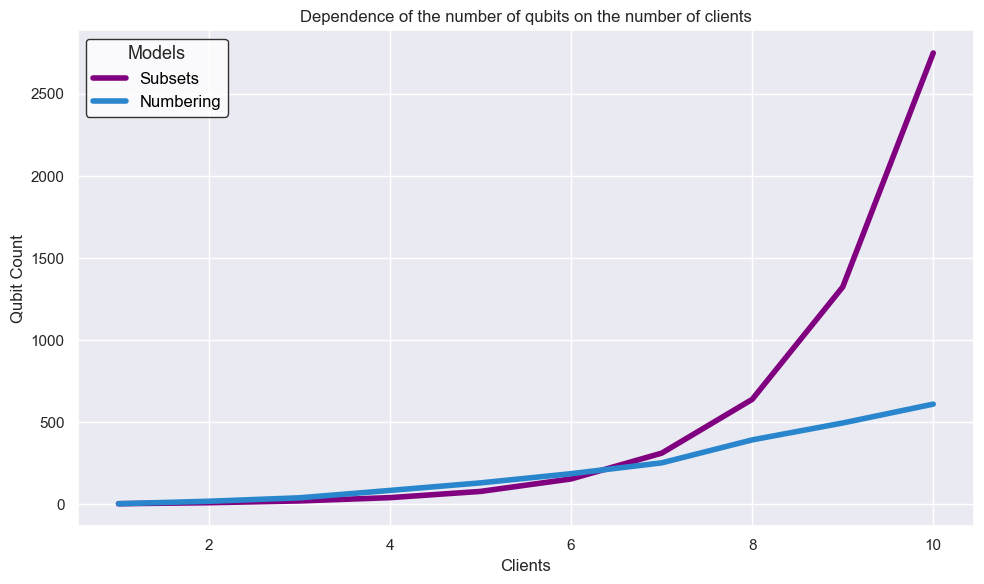

In [199]:
sns.set_theme(palette="pastel")

x1 = []
y1 = []
x2 = []
y2 = []

def add_point(clients, time, group=1):
    if group == 1:
        x1.append(clients)
        y1.append(time)
    else:
        x2.append(clients)
        y2.append(time)

for Clients in range(1, 11):
    t = GenerateTestCase(Clients, 1, 1, 100)
    q7 = constructQUBO(t)
    constraint_7(t, q7)
    q10 = constructQUBO(t)
    constraint_10(t, q10)
    add_point(Clients, len(q7.GetLists()[0]), 1)
    add_point(Clients, len(q10.GetLists()[0]), 2)

plt.figure(figsize=(10, 6))
plt.title("Dependence of the number of qubits on the number of clients")
plt.xlabel("Clients")
plt.ylabel("Qubit Count")

l1 = plt.plot(x1, y1, color='#800080', linewidth=4, label='Subsets')
l2 = plt.plot(x2, y2, color='#2986CC', linewidth=4, label='Numbering')

plt.legend(
    fontsize=12,
    facecolor='#FFFFFF',
    edgecolor='black',
    labelcolor='black',
    title='Models',
    title_fontsize='13'
)

plt.tight_layout()

plt.show()

Зависимость времени построения матрицы от количества клиентов

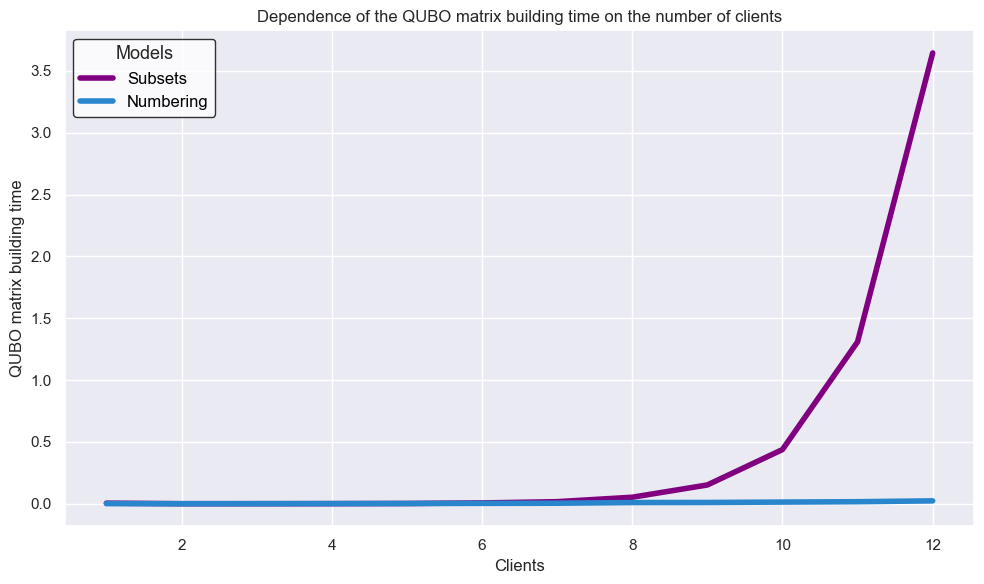

In [200]:
sns.set_theme(palette="pastel")

x1 = []
y1 = []
x2 = []
y2 = []

for Clients in range(1, 13):
    t = GenerateTestCase(Clients, 1, 1, 100)
    st1 = datetime.now()
    q7 = constructQUBO(t)
    constraint_7(t, q7)
    t1 = (datetime.now() - st1).total_seconds()
    st2 = datetime.now()
    q10 = constructQUBO(t)
    constraint_10(t, q10)
    t2 = (datetime.now() - st2).total_seconds()
    add_point(Clients, t1, 1)
    add_point(Clients, t2, 2)

plt.figure(figsize=(10, 6))
plt.title("Dependence of the QUBO matrix building time on the number of clients")
plt.xlabel("Clients")
plt.ylabel("QUBO matrix building time")

l1 = plt.plot(x1, y1, color='#800080', linewidth=4, label='Subsets')
l2 = plt.plot(x2, y2, color='#2986CC', linewidth=4, label='Numbering')

plt.legend(
    fontsize=12,
    facecolor='#FFFFFF',
    edgecolor='black',
    labelcolor='black',
    title='Models',
    title_fontsize='13'
)

plt.tight_layout()

plt.show()

In [203]:
def GenGraph(clientsNum: int, depotsNum: int, carsNum: int, maxPos: int, samplesAmount: int, minIt: int, maxIt: int):
    ans_q7_sim = []
    time_q7_sim = []
    ans_q10_sim = []
    time_q10_sim = []
    ans_q7_qdeep = []
    time_q7_qdeep = []
    ans_q10_qdeep = []
    time_q10_qdeep = []
    ans_compl = []
    time_compl = []
    ans_gen = []
    time_gen = []

    for i in range(samplesAmount):
        test = GenerateTestCase(clientsNum, depotsNum, carsNum, maxPos)
        q7 = constructQUBO(test)
        constraint_7(test, q7)
        q10 = constructQUBO(test)
        constraint_10(test, q10)

        bestAns = 1e9
        itCount = random.randint(minIt, maxIt)

        sol1, _, t = SolveSimulatedAnnealing(q7, test, itCount)
        if sol1.CheckErrors(test) == "":
            ans_q7_sim.append(sol1.GetCost(test))
            time_q7_sim.append(t)
            bestAns = min(bestAns, ans_q7_sim[-1])

        print("sol1 finished in", t)

        sol2, _, t = SolveSimulatedAnnealing(q10, test, itCount)
        if sol2.CheckErrors(test) == "":
            ans_q10_sim.append(sol2.GetCost(test))
            time_q10_sim.append(t)
            bestAns = min(bestAns, ans_q10_sim[-1])

        print("sol2 finished in", t)

        sol3, _, t = SolveQDeepHybridSolver(q7, test, itCount)
        if sol3.CheckErrors(test) == "":
            ans_q7_qdeep.append(sol3.GetCost(test))
            time_q7_qdeep.append(t)
            bestAns = min(bestAns, ans_q7_qdeep[-1])

        print("sol3 finished in", t)

        sol4, _, t = SolveQDeepHybridSolver(q10, test, itCount)
        if sol4.CheckErrors(test) == "":
            ans_q10_qdeep.append(sol4.GetCost(test))
            time_q10_qdeep.append(t)
            bestAns = min(bestAns, ans_q10_qdeep[-1])

        print("sol4 finished in", t)

        sol5, t = CompleteSearch(test)
        if sol5.CheckErrors(test) == "":
            ans_compl.append(sol5.GetCost(test))
            time_compl.append(t)
            bestAns = min(bestAns, ans_compl[-1])

        print("sol5 finished in", t)

        sol6, _, t = SolveGenAlgo(test, random.uniform(minIt/1000, maxIt/1000))
        if sol6.CheckErrors(test) == "":
            ans_gen.append(sol6.GetCost(test))
            time_gen.append(t)
            bestAns = min(bestAns, ans_gen[-1])

        print("sol6 finished in", t)

        if sol1.CheckErrors(test) == "":
            ans_q7_sim[-1] /= bestAns
        if sol2.CheckErrors(test) == "":
            ans_q10_sim[-1] /= bestAns
        if sol3.CheckErrors(test) == "":
            ans_q7_qdeep[-1] /= bestAns
        if sol4.CheckErrors(test) == "":
            ans_q10_qdeep[-1] /= bestAns
        if sol5.CheckErrors(test) == "":
            ans_compl[-1] /= bestAns
        if sol6.CheckErrors(test) == "":
            ans_gen[-1] /= bestAns
        
        print(f"It: {i+1}/{samplesAmount}")

    plt.figure(figsize=(12, 7))
    plt.title("Performance Comparison of Different Optimization Methods (Random Test Data)")
    plt.xlabel("Solution Quality (Normalized)")
    plt.ylabel("Computation Time (seconds)")
    plt.grid(True, alpha=0.3)

    plt.scatter(ans_q7_sim, time_q7_sim, color='#800080', alpha=0.5, 
                label='Subsets (Simulation)', s=600)
    plt.scatter(ans_q10_sim, time_q10_sim, color='#2986CC', alpha=0.5, 
                label='Numbering (Simulation)', s=600)
    plt.scatter(ans_q7_qdeep, time_q7_qdeep, color='#6AA84F', alpha=0.5, 
                label='Subsets (QDeep)', s=600)
    plt.scatter(ans_q10_qdeep, time_q10_qdeep, color='#F1C232', alpha=0.5, 
                label='Numbering (QDeep)', s=600)
    plt.scatter(ans_compl, time_compl, color='#CC0000', alpha=0.5, 
                label='Complete search', s=600)
    plt.scatter(ans_gen, time_gen, color='#CE7E00', alpha=0.5, 
                label='Genetic algorithm', s=600)

    plt.legend(
        fontsize=12,
        facecolor='#FFFFFF',
        edgecolor='black',
        labelcolor='black',
        title='Optimization Methods',
        title_fontsize='14',
        markerscale=0.5,
        handletextpad=0.5,
        borderpad=1
    )

    plt.tight_layout()
    plt.show()

sol1 finished in 18.179143
sol2 finished in 28.075239
sol3 finished in 31.901901
sol4 finished in 35.944938
sol5 finished in 0.001572
sol6 finished in 7.893508
It: 1/8
sol1 finished in 11.690893
sol2 finished in 18.693023
sol3 finished in 31.462313
sol4 finished in 36.384888
sol5 finished in 0.000672
sol6 finished in 6.381247
It: 2/8
sol1 finished in 19.23249
sol2 finished in 30.00297
sol3 finished in 31.975048
sol4 finished in 35.002809
sol5 finished in 0.00068
sol6 finished in 5.637986
It: 3/8
sol1 finished in 20.452222
sol2 finished in 30.002229
sol3 finished in 32.19331
sol4 finished in 44.632117
sol5 finished in 0.000687
sol6 finished in 4.207681
It: 4/8
sol1 finished in 7.560905
sol2 finished in 12.152027
sol3 finished in 22.871826
sol4 finished in 34.917623
sol5 finished in 0.000699
sol6 finished in 2.342212
It: 5/8
sol1 finished in 19.619785
sol2 finished in 30.003764
sol3 finished in 34.90035
sol4 finished in 36.674946
sol5 finished in 0.000727
sol6 finished in 2.530439
It: 6/

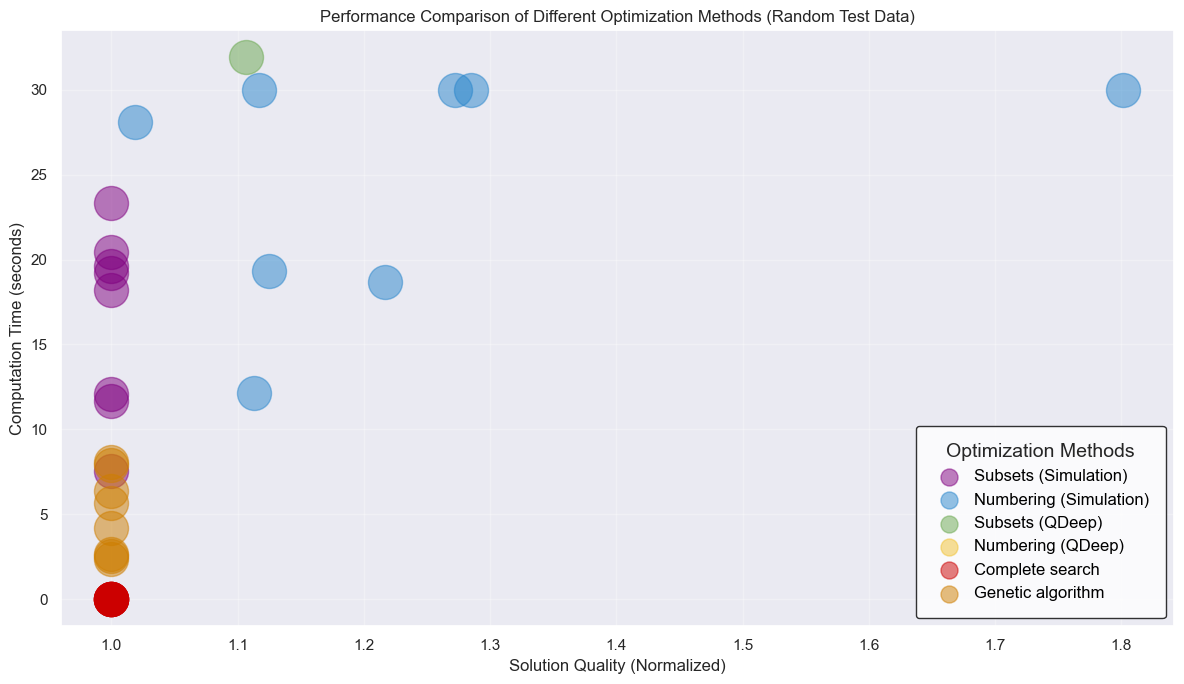

In [209]:
GenGraph(5, 1, 1, 100, 8, 1000, 10000)